# セグメンテーション
KaggleのTGS Salt Identification Challengeのデータセットを使用し、セグメンテーションを行います。

TGS Salt Identification Challenge | Kaggle

セグメンテーション手法としてU-Net[1]を使います。

[1]O.Ronneberger, P.Fischer, T.Brox. U-Net: Convolutional Networks for Biomedical Image Segmentation. Medical Image Computing and Computer-Assisted Intervention (MICCAI), Springer, LNCS, Vol.9351: 234–241, 2015

https://arxiv.org/pdf/1505.04597.pdf

## グーグルコラボを利用する際の事前処理

#### Google Drive をマウント

Google Colab 自体も Google Drive 上のただの Jupyter ファイルみたいなものなので、
データもそこで管理できるのであれば管理が統一されて便利。
参考にしたのはこちらGoogle Colab Free GPU Tutorial - Medium
まずは、必要なパッケージを取得しておく。

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130912 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


#### 以下を実行すると、認証情報を取得するための許可を求められるので、許可してトークンを発行し、テキストボックスに貼り付ける。

In [0]:
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

#### 以下実行により、今度は google-drive-ocamlfuse によるアクセスの許可を聞かれる。これも許可する。

In [0]:
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


#### drive 以下に マイドライブ以下のファイル/フォルダ全て がマウントされる。

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive
!ls drive

 AIジョブカレ	     WinPython-64bit-3.6.4.0Qt5b5
'Colab Notebooks'    松尾研究室講座
 images.zip	     無題のスプレッドシート.ods
'Jupyter Notebook'   無題のドキュメント.odt
 masks.zip	     論文テンプレート.pptx（復元済み）.pptx


**<現在のディレクトリを確認>**

In [0]:
%pwd

'/content'

**＜一つ画像を可視化してみる＞**

[[[131 131 131]
  [131 131 131]
  [131 131 131]
  ...
  [ 95  95  95]
  [100 100 100]
  [105 105 105]]

 [[131 131 131]
  [131 131 131]
  [134 134 134]
  ...
  [ 85  85  85]
  [ 89  89  89]
  [ 95  95  95]]

 [[135 135 135]
  [135 135 135]
  [137 137 137]
  ...
  [ 78  78  78]
  [ 81  81  81]
  [ 86  86  86]]

 ...

 [[140 140 140]
  [144 144 144]
  [146 146 146]
  ...
  [ 94  94  94]
  [ 91  91  91]
  [ 88  88  88]]

 [[144 144 144]
  [141 141 141]
  [140 140 140]
  ...
  [118 118 118]
  [116 116 116]
  [113 113 113]]

 [[146 146 146]
  [137 137 137]
  [133 133 133]
  ...
  [138 138 138]
  [139 139 139]
  [139 139 139]]]


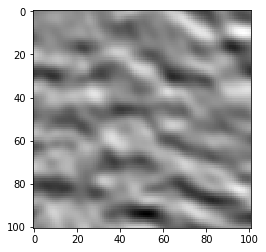

In [0]:
import cv2
 
im = cv2.imread('drive/Colab Notebooks/unet-master/data/membrane/train/image/000e218f21.png')
print(im)
from matplotlib import pyplot as plt
plt.imshow(im)

＜ディレクトリを変更＞

In [0]:
%cd drive/Colab Notebooks/unet-master

/content/drive/Colab Notebooks/unet-master


In [0]:
%pwd

'/content/drive/Colab Notebooks/unet-master'

＜トレインネットの記述を実施＞

In [0]:
from model import *
from data import *

Using TensorFlow backend.


＜学習を開始＞

In [0]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'data/membrane/train','image','label',data_gen_args,save_to_dir = None)
model = unet()
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=200,epochs=1,callbacks=[model_checkpoint])

W0617 01:44:37.029616 140427120670592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0617 01:44:37.093597 140427120670592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0617 01:44:37.106810 140427120670592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0617 01:44:37.174169 140427120670592 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0617 01:44:37.260797 140427120670592 deprec

Epoch 1/1
Found 4000 images belonging to 1 classes.
Found 4000 images belonging to 1 classes.
200/200 [==============================] - 3312s 17s/step - loss: 0.6023 - acc: 0.7471

Epoch 00001: loss improved from inf to 0.60228, saving model to unet_membrane.hdf5


＜予測を実施＞

In [16]:
testGene = testGenerator("data/membrane/test")
model = unet()
model.load_weights("unet_membrane.hdf5")
results = model.predict_generator(testGene,30,verbose=1)
saveResult("data/membrane/test",results)

/content/drive/Colab Notebooks/unet-master/model.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


30/30 [==============================] - 59s 2s/step


/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: data/membrane/test/0_predict.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0617 02:49:06.140134 140427120670592 util.py:61] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: data/membrane/test/1_predict.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0617 02:49:08.254037 140427120670592 util.py:61] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:141: UserWarning: data/membrane/test/2_predict.png is a low contrast image
  warn('%s is a low contrast image' % fname)
W0617 02:49:10.097336 140427120670592 util.py:61] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prio

# 【問題2】コードリーディング
論文[1]に目を通した上で、上記実装のコードリーディングを行ってください。

In [ ]:

############################
# モデルとデータを全て(*)インポート
############################
from model import *
from data import *

#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

####################
# 学習データの増強を行う
####################
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'data/membrane/train','image','label',data_gen_args,save_to_dir = None)



####################
# モデルのインスタンス化
####################
model = unet()


"""
def unet(pretrained_weights = None,input_size = (256,256,1)):

    #U字の下りを行う畳み込みとプーリング
    
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    #U字の上りを行う畳み込みと結合
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model
"""






##########################################
# モデルの学習と最も目的関数の下がった際の重みを保存
##########################################
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=300,epochs=1,callbacks=[model_checkpoint])


"""
model_checkpoint
→Epoch終了後の各数値（acc,loss,val_acc,val_loss)を監視して条件が揃った場合モデルを保存。

　例えば下記の使い方の設定方法を設定し学習を行うと「Val_loss」を監視。
　1Epoch終了後に「保存されている重みの「Val_loss」＞学習後の「Val_loss」」
　の場合の時だけモデル全体を保存していく。

　これにより適当にEpochを決めて過学習となってしまった場合でもモデルファイルはそれ以前の「Val_loss」が最小の時のモデルファイルが
 保存されるのでやり直しがなくて便利です。
 
 
 from keras.callbacks import ModelCheckpoint
 modelCheckpoint = ModelCheckpoint(filepath = 'XXX.h5',
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=False,
                                  mode='min',
                                  period=1)
                                  
filepath: 重みのファイル名そのものを指示(ex. XXX.h5)
monitor: 監視する値（acc,loss,val_acc,val_loss)
verbose: 0=結果非表示　1=結果表示

save_best_only: True=判定結果から保存を決定。False=後述の'period'の間隔で保存
mode: 判定条件（auto、max、min）max=「acc、val_acc」、min=「loss、val_loss」
save_weights_only: True=モデルの重みが保存。False=モデル全体を保存 
period: 何エポックごとに保存するか

"""


################
# 画像の水増しを行う
################

testGene = testGenerator("data/membrane/test")

"""
def testGenerator(test_path,num_image = 30,target_size = (256,256),flag_multi_class = False,as_gray = True):
    for i in range(num_image): #設定した画像数繰り返す
        img = io.imread(os.path.join(test_path,"%d.png"%i),as_gray = as_gray) #0から順にグレイイメージで画像を読み込む 
        img = img / 255 #正則化する
        img = trans.resize(img,target_size) #画像サイズを(256,256)に変更する
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        yield img
        
※
yieldは、関数を一時的に実行停止させることが出来る機能を持つ文。
その時点での戻り値を返し、そしてまた再開させることができる。
for文を一度回すたびに画像を返すため、yieldを活用する。
"""



################
# 画像の予測と保存
################
results = model.predict_generator(testGene,30,verbose=1)
saveResult("data/membrane/test",results)